In [1]:
%matplotlib ipympl
from ipywidgets import interact, FloatSlider, IntSlider
import numpy as np
from scipy.stats import norm, binom, nbinom, gamma
import matplotlib.pyplot as plt
from collections import Counter

# Part 1: Gaussian model with known variance

We consider a dataset which we would like to describe with a normal distribution. We assume that the variance is already known and equal to $\sigma^2 = 4$. Our goal is now to perform Bayesian inference on the mean $\mu$ of the normal model.

In this experiment we are using simulated data, using the following script:

In [2]:
sigma = 2  # Assumed to be known
data = norm.rvs(loc=5, scale=sigma, size=30)

We consider a Bayesian model composed of a Gaussian likelihood with i.i.d. data:
$$p(x_1, \dotsc, x_N | \mu) = \prod_{n=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(x_n-\mu)^2}{2 \sigma^2} \right)$$
and a Gaussian prior:
$$p(\mu) = \frac{1}{\sqrt{2 \pi \tau_0^2}} \exp \left( - \frac{(\mu - m_0)^2}{2 \tau_0^2} \right)$$

We have seen during the lecture that such a model corresponds to normal posterior distribution $p(\mu | x_1, \dotsc, x_N)$ of mean $m_N$ and variance $\tau_N^2$ satisfying:
$$m_N = \frac{\sigma^2 m_0 + N \tau_0^2 \hat{\mu}_{MLE}}{\sigma^2 + N \tau_0^2} \qquad \qquad \frac{1}{\tau_N^2} = \frac{1}{\tau_0^2} + \frac{N}{\sigma^2}$$

In [3]:
def get_gauss_post(prior_mean, prior_std, data, sigma):
    N = len(data)
    post_mean = (sigma**2 * prior_mean + (prior_std**2) * data.sum()) / (sigma**2 + N * (prior_std**2))
    post_std = 1 / np.sqrt(1 / (prior_std**2) + N / (sigma**2))
    return post_mean, post_std

## Influence of the prior on the posterior

With the following code, you can observe the effect of the choice of a prior on the posterior distribution. You can directly interact with $m_0$ and $\tau_0$ and test several values. On the plot, you can observe the prior distribution, the likelihood of the observed dataset and the posterior distribution. 

Note that, on this plot, the likelihood is not of the same nature as the prior and posterior: it is a distribution over the data space, while the prior and posterior are distributions over the parameter space. We represent them on the same plot, but please be careful and keep this in mind when interpreting the plots!

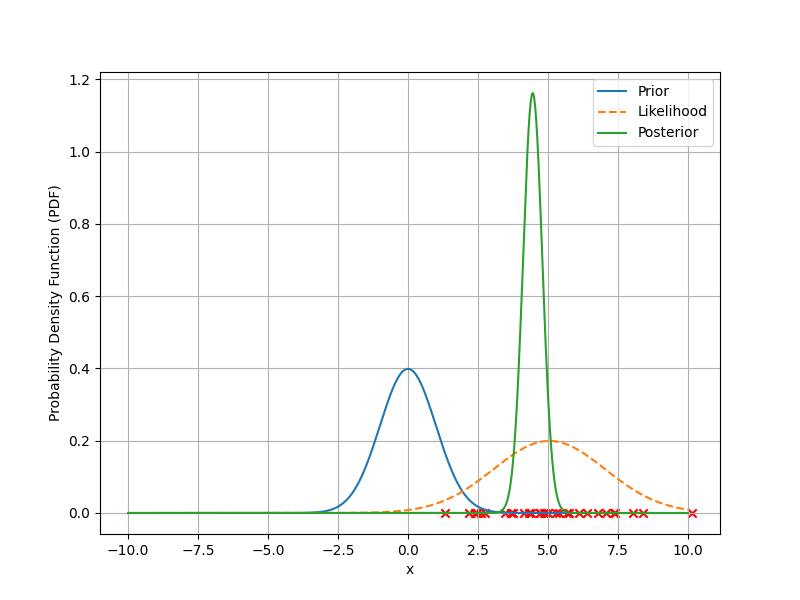

interactive(children=(FloatSlider(value=0.0, description='$m_0$', max=10.0, min=-10.0), FloatSlider(value=1.0,…

In [4]:
x_gaussian = np.linspace(-10, 10, 500)

fig_gauss = plt.figure(figsize=(8, 6))

# Prior
prior_mean, prior_std = 0, 1
prior_values = norm.pdf(x_gaussian, prior_mean, prior_std)
gauss_prior, = plt.plot(x_gaussian, prior_values, label='Prior')

# Data
points = plt.scatter(data, [0] * len(data), c='red', marker='x')

# Likelihood
likelihood_mean, likelihood_std = data.sum() / len(data), 2
likelihood_values = norm.pdf(x_gaussian, likelihood_mean, likelihood_std)
gauss_likelihood, = plt.plot(x_gaussian, likelihood_values, label='Likelihood', linestyle='--')

# Posterior
post_mean, post_std = get_gauss_post(prior_mean, prior_std, data, sigma)
post_values = norm.pdf(x_gaussian, post_mean, post_std)
gauss_post, = plt.plot(x_gaussian, post_values, label='Posterior')

plt.xlabel("x")
plt.ylabel("Probability Density Function (PDF)")
plt.grid(True)
plt.legend()
plt.show()

def update_gaussian(mean, std, n_points):
    prior_values = norm.pdf(x_gaussian, mean, std)
    gauss_prior.set_ydata(prior_values)
    
    post_mean, post_std = get_gauss_post(mean, std, data[:n_points], sigma)
    post_values = norm.pdf(x_gaussian, post_mean, post_std)
    gauss_post.set_ydata(post_values)
    
    likelihood_mean, likelihood_std = data[:n_points].sum() / n_points, 2
    likelihood_values = norm.pdf(x_gaussian, likelihood_mean, likelihood_std)
    gauss_likelihood.set_ydata(likelihood_values)

    
    points.set_sizes([30] * n_points + [0] * (len(data) - n_points))
    
    fig_gauss.suptitle(f"Gaussian prior wth $m_0$ = {mean:.2f} and $\\tau_0$ = {std:.2f}")

interact(update_gaussian,
         mean=FloatSlider(value=0, min=-10, max=10, description="$m_0$"),
         std=FloatSlider(value=1, min=0.05, max=5, description="$\\tau_0$"),
         n_points=IntSlider(value=5, min=1, max=len(data), description="$N$"));

### Question 1

Consider first a small variance, for instance $\tau_0 = 1$ or lower. Observe the influence of $m_0$ over the posterior. In which case will the choice of $m_0$ be particularly critical: for a smaller dataset or a larger dataset? 

### Question 2

Consider now a larger variance, for instance $\tau_0 = 3$ or larger. Observe the influence of $m_0$ over the posterior. Would you rather make this choice of a variance when you have a smaller dataset or a larger dataset?

_Remark:_ We call such a prior an _uninformative prior_: it lets the data speak by itself and does not guide much the value of the posterior. 

## Predictive checking

Be it a prior or a posterior, a distribution over the parameter space is not always easy to interpret, since it does not necessarily correlate in an interpretable manner with the observation space. In this example, since we are considering the simple and well-known normal distribution, it is easy to give an interpretation of the distribution of the mean, but when considering other more complex models, this might not be the case anymore. 

Predictive checking is a way to translate the uncertainty over the model (assessed by the prior and/or the posterior) into the data space. Given a distribution $q(\theta)$ over models, the predictive checking distribution is defined as:

$$
p(x) = \int_\theta p(x | \theta) \, q(\theta) \, d\theta
$$

In particular, when $q(\theta)$ is the prior distribution, we call this the **prior predictive checking distribution** and when $q(\theta)$ is the posterior distribution, we call this the **posterior predictive checking distribution**.

### Question 3 (difficult)

Show that the predictive checking distribution is normal for a normal likelihood when $q$ is a normal distribution of mean $m$ and variance $s^2$.

_Hint_: Write the product of the exponentials under the integral as the exponential of a sum, and develop the terms to obtain a normal distribution over $\mu$.

By pushing the calculations further, it is possible to check that this is actually a normal distribution of mean $m$ and of variance $\sigma^2 + s^2$. 

In particular, this makes it possible to express the prior predictive checking distribution as:

$$
p(x) = \mathcal{N}\left(x ; m_0, s^2 + \tau_0^2\right)
$$
and the posterior predictive checking distribution as:

$$
p(x | x_1, \dotsc, x_N) = \mathcal{N}\left(x ; m_N, s^2 + \tau_N^2\right)
$$

The following code implements an interactive visualization of the prior and posterior predictive sampling distributions.

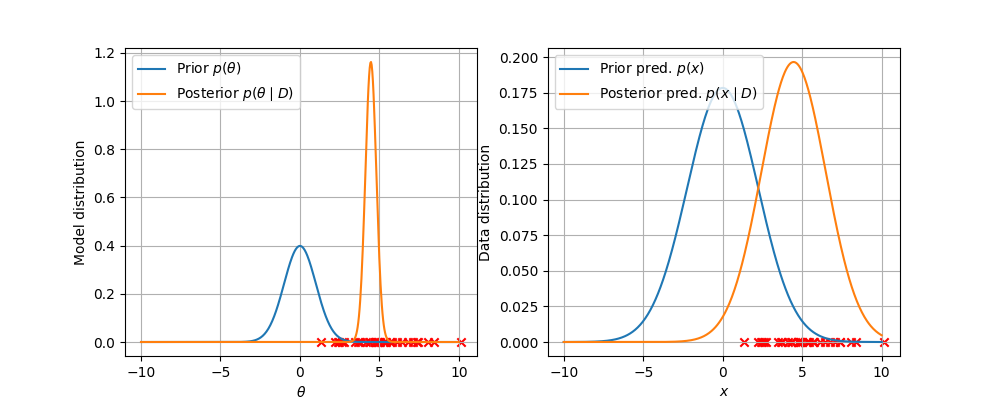

interactive(children=(FloatSlider(value=0.0, description='$\\mu$', max=10.0, min=-10.0), FloatSlider(value=1.0…

In [10]:
x_gaussian = np.linspace(-10, 10, 500)

fig_gauss,axs = plt.subplots(1, 2, figsize=(10, 4))

# Prior
prior_mean, prior_std = 0, 1
prior_values = norm.pdf(x_gaussian, prior_mean, prior_std)
gauss_prior, = axs[0].plot(x_gaussian, prior_values, label='Prior $p(\\theta)$')

# Plot the data in both
points_0 = axs[0].scatter(data, [0] * len(data), c='red', marker='x')
points_1 = axs[1].scatter(data, [0] * len(data), c='red', marker='x')

# Posterior
post_mean, post_std = get_gauss_post(prior_mean, prior_std, data, sigma)
post_values = norm.pdf(x_gaussian, post_mean, post_std)
gauss_post, = axs[0].plot(x_gaussian, post_values, label='Posterior $p(\\theta \\mid D)$')

axs[0].set_xlabel("$\\theta$")
axs[0].set_ylabel("Model distribution")
axs[0].grid(True)
axs[0].legend()

# Prior predictive distribution
prior_pred_values = norm.pdf(x_gaussian, prior_mean, np.sqrt(prior_std**2 + sigma**2))
gauss_prior_pred, = axs[1].plot(x_gaussian, prior_pred_values, label='Prior pred. $p(x)$')

# Posterior predictive distribution
post_pred_values = norm.pdf(x_gaussian, post_mean, np.sqrt(post_std**2 + sigma**2))
gauss_post_pred, = axs[1].plot(x_gaussian, post_pred_values, label='Posterior pred. $p(x \\mid D)$')

axs[1].set_xlabel("$x$")
axs[1].set_ylabel("Data distribution")
axs[1].grid(True)
axs[1].legend()

plt.show()

def update_gaussian(prior_mean, prior_std, n_points):
    # Prior
    prior_values = norm.pdf(x_gaussian, prior_mean, prior_std)
    gauss_prior.set_ydata(prior_values)
    
    # Posterior
    post_mean, post_std = get_gauss_post(prior_mean, prior_std, data[:n_points], sigma)
    post_values = norm.pdf(x_gaussian, post_mean, post_std)
    gauss_post.set_ydata(post_values)
    
    # Points
    points_0.set_sizes([30] * n_points + [0] * (len(data) - n_points))
    points_1.set_sizes([30] * n_points + [0] * (len(data) - n_points))
    
    # Prior predictive
    prior_pred_values = norm.pdf(x_gaussian, prior_mean, np.sqrt(prior_std**2 + sigma**2))
    gauss_prior_pred.set_ydata(prior_pred_values)
    
    # Posterior predictive
    post_pred_values = norm.pdf(x_gaussian, post_mean, np.sqrt(post_std**2 + sigma**2))
    gauss_post_pred.set_ydata(post_pred_values)
    
    fig_gauss.suptitle(f"Gaussian prior with μ = {prior_mean:.2f} and σ = {prior_std:.2f}")

interact(update_gaussian,
         prior_mean=FloatSlider(value=0, min=-10, max=10, description="$\\mu$"),
         prior_std=FloatSlider(value=1, min=0.1, max=20, description="$\\sigma$"),
         n_points=IntSlider(value=5, min=1, max=len(data), description="$N$"));

# Part 2: Bayesian modeling workflow: From a dataset to a posterior

The Deutsche Bahn is world-famous for the stunning quality of its services, and in particular when it comes to S-Bahn in Hamburg. Our goal, in this problem, is to propose a probabilistic model of the occurence of incidents on the S Bahn network of Hamburg. To do so, we will use a Bayesian approach and exploit data collected from the reports published by Hamburg S Bahn on Twitter. 

Our dataset consists of the observation of the number of reported daily perturbations in a period of 30 days. 

In [11]:
perturbations = np.array([ 2, 0, 1, 0, 1, 4, 0, 2, 1, 1, 2, 1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 3, 1, 1, 2, 0, 0, 1, 0, 0 ])

## Choice of a model

In order to choose a relevant probabilistic model, we need to understand the nature and characteristics of the problem. 

The collected data represent the number of events occurring in a fixed interval of time. We can assume these events to be independent. This hypothesis is not necessarily realistic: it may be the case that a perturbation on one line has effects on a later perturbation on another line. However, since most of the perturbations correspond to police interventions or technical issues, the hypothesis seems rather appropriate. 

The **Poisson distribution** is actually adapted to model such situations. We remind that the Poisson distribution is a distribution over $\mathbb{N}$ which describes the number of occurrences of independent events in a fixed time interval. This probability is given by:

$$
p(k \, | \, \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}
$$

where $\lambda > 0$ is a parameter that interprets as the mean number of events expecting in the given interval. 

In addition, we assume that the measured numbers are independent from one day to the other, which means that the collected observations are independent and identically distributed (i.i.d.). This allows us to write the likelihood of the model as:

$$
p(x_1, \dotsc, x_N) = \prod_{n=1}^N \frac{\lambda^{x_n} e^{-\lambda}}{x_n!}
$$



We will then try to get a good posterior estimation of $\lambda$. 

As discussed during the lecture, a Bayesian model is not given only by the likelihood, but also by the choice of a prior. This prior will have to be chosen to reflect our expert knowledge on the domain, but also to guarantee reasonable computations. We saw during the lecture that, for some likelihoods, there exists a **conjugate prior**, i.e. a distribution family, which, when chosen as a prior, leads to posterior of the same family. 

### Question 4: 

Show that the Gamma distribution is a conjugate prior for the Poisson likelihood. Provide the values of the new parameters. 

We remind you that the Gamma distribution, of parameters $(\alpha, \beta)$ is defined as:

$$
p(\lambda) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{- \beta \lambda}
$$

The following code implements the update of the posterior parameters based on the observations and the parameters of the prior.

In [12]:
def get_poisson_post(prior_alpha, prior_beta, data):
    N = len(data)
    post_alpha = prior_alpha + data.sum()
    post_beta = prior_beta + N
    return post_alpha, post_beta

## Choice of the prior parameters

It is not sufficient to choose the distribution family of the prior, we also need to pick the associated parameters. Unlike for the normal distribution where it was fairly easy to interpret the parameters, it is less convenient to propose some initial values for $\alpha$ and $\beta$ in the context of a Gamma distribution. 

Before finding an optimal prior, we must start by considering which characteristics we want our prior to have:

* **Expert knowledge:** We have some information about the domain, prior to any observation of the data. Despite the arguable quality of the S-Bahn, we do not expect more than 3-4 perturbations a day, in general. We also expect to have often at least one perturbation a day.  
* **Informativeness:** The dataset we collected is of a reasonable size (30 observations), but not statistically significant. We would like our prior to constrain the range of values of $\lambda$, but not to override the likelihood too much. 

We propose to use prior predictive checking to assess the quality of the chosen prior. It is admitted (but it is a good exercise to prove it) that the prior predictive checking distribution is the _negative binomial_ distribution:

$$
p(x) = \binom{\alpha + x - 1}{x} \left( \frac{\beta}{\beta + 1} \right)^\alpha \left( \frac{1}{\beta + 1} \right)^y
$$

### Question 5

Using the interactive plot below, select some values for $\alpha$ and $\beta$ which seem coherent with the expert knowledge. 

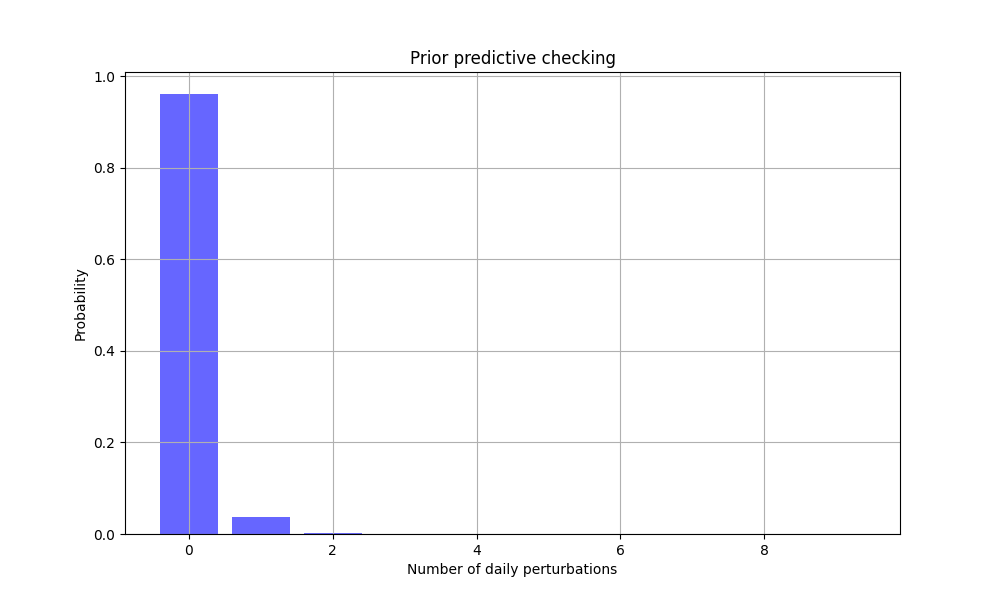

interactive(children=(IntSlider(value=5, description='$\\alpha$', min=1), IntSlider(value=5, description='$\\b…

<function __main__.plot_negative_binomial(alpha, B)>

In [13]:
x = np.arange(0, 10)
alpha = 1
B = 25

pmf_values = nbinom.pmf(x, alpha, B / (B + 1))

plt.figure(figsize=(10, 6))
hist = plt.bar(x, pmf_values, color='blue', alpha=0.6)
plt.title('Prior predictive checking')
plt.xlabel('Number of daily perturbations')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

def plot_negative_binomial(alpha, B):
    p = B / (B + 1)
    pmf_values = nbinom.pmf(x, alpha, B / (B + 1))
    for bar, new_height in zip(hist, pmf_values):
        bar.set_height(new_height)


# Interactive widgets to control parameters
alpha_slider = IntSlider(min=1, max=100, step=1, value=5, description='$\\alpha$')
beta_slider = IntSlider(min=1, max=100, step=1, value=5, description='$\\beta$')

# Use 'interact' to create the interactive plot
interact(plot_negative_binomial, alpha=alpha_slider, B=beta_slider)

## Model checking

Now that you have fully configured your model (choice of a likelihood function, choice of a prior family, choice of the parameters of the prior), you can run the inference, and control the produced model. 

In [14]:
alpha = 1 # Your choice of alpha here
beta =  2 # Your choice of beta here

### Question 6

Using the function `get_poisson_post` introduced earlier, complete the following code to plot the prior and the posterior distributions.  

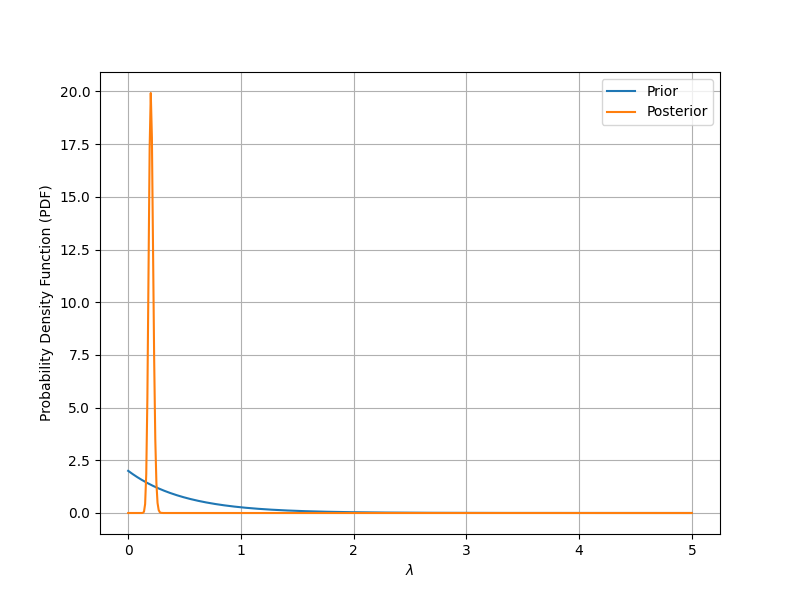

In [16]:
x_gamma = np.linspace(0, 5, 500)

# Plot the Gamma distribution in a separate figure
fig_gamma = plt.figure(figsize=(8, 6))

prior_values = gamma.pdf(x_gamma, a=alpha, scale=1/beta)
plt.plot(x_gamma, prior_values, linestyle='-', label='Prior')

alpha_post, beta_post = get_poisson_post(alpha, beta, prior_values)# Insert your code here

prior_values = gamma.pdf(x_gamma, a=alpha_post, scale=1/beta_post)
plt.plot(x_gamma, prior_values, linestyle='-', label='Posterior')

plt.xlabel("$\\lambda$")
plt.ylabel("Probability Density Function (PDF)")
plt.grid(True)
plt.legend()
plt.show()

As seen previously, knowing the distribution (prior or posterior) over the models is not sufficient to conclude. We use predictive checking to check the adequation between the predictions of the model and the actual observations. 

### Question 7

we sample the obtained posterior predictive checking to verify some expected outcomes. Do they seem coherent with the observations? If not, the model is probably not good, and you need to refine it by readapting the parameters $\alpha$ and $\beta$ of the prior. Modify them until you obtain a satisfying result. This iterative process is the core of the Bayesian modeling workflow. 

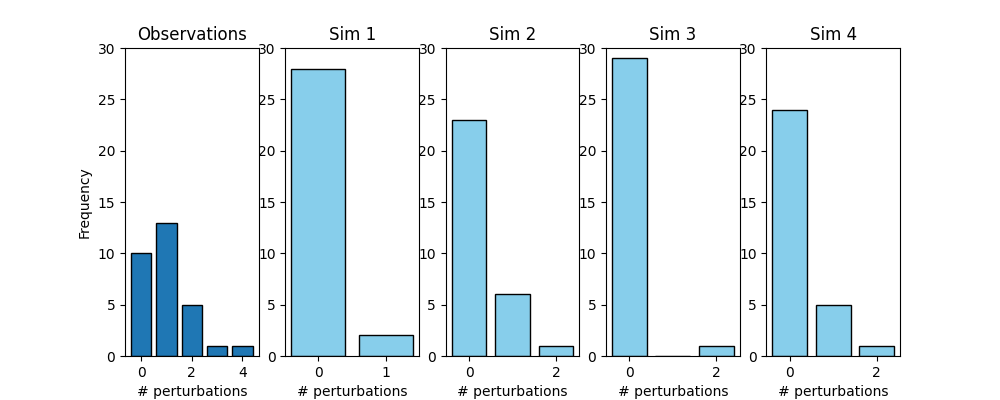

In [17]:
N = len(perturbations)
n_sim = 4

fig_sims,axs = plt.subplots(1, 1 + n_sim, figsize=(10, 4))

# Running simulations
simulated_perturbations = np.random.negative_binomial(alpha_post, beta_post / (beta_post + 1), N * n_sim)
simulated_perturbations = simulated_perturbations.reshape(n_sim, N)


# Computing the max y value for the plots
ymax = Counter(perturbations).most_common(1)[0][1]
for i in range(n_sim):
    ymax = max(ymax, Counter(simulated_perturbations[i,:]).most_common(1)[0][1])
ymax = ymax + 1


# Plotting the histogram of observations
data = perturbations
axs[0].hist(data, bins=np.arange(data.min() - 0.5, data.max() + 1.5, 1), edgecolor='black', rwidth=0.8)

axs[0].set_xlabel("# perturbations")
axs[0].set_ylabel("Frequency")
axs[0].set_ylim(0, ymax)
axs[0].grid(False)
axs[0].set_title("Observations")

for i in range(n_sim):
    data = simulated_perturbations[i,:]
    axs[i+1].hist(data, bins=np.arange(data.min() - 0.5, data.max() + 1.5, 1), edgecolor='black', rwidth=0.8, color='skyblue')
    axs[i+1].set_ylim(0, ymax)
    axs[i+1].set_xlabel("# perturbations")
    axs[i+1].grid(False)
    axs[i+1].set_title(f"Sim {i+1}")

plt.show()